In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

cudnn.benchmark = True
plt.ion()   # 대화형 모드

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
# modified from https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# Position embedding utils
# --------------------------------------------------------

import numpy as np

import torch

# --------------------------------------------------------
# relative position embedding
# References: https://arxiv.org/abs/2009.13658
# --------------------------------------------------------
def get_2d_relative_pos_embed(embed_dim, grid_size):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, grid_size*grid_size]
    """
    pos_embed = get_2d_sincos_pos_embed(embed_dim, grid_size)
    relative_pos = 2 * np.matmul(pos_embed, pos_embed.transpose()) / pos_embed.shape[1]
    return relative_pos


# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [3]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import math
import torch
from torch import nn
import torch.nn.functional as F


def pairwise_distance(x):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_inner = -2*torch.matmul(x, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square + x_inner + x_square.transpose(2, 1)


def part_pairwise_distance(x, start_idx=0, end_idx=1):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_part = x[:, start_idx:end_idx]
        x_square_part = torch.sum(torch.mul(x_part, x_part), dim=-1, keepdim=True)
        x_inner = -2*torch.matmul(x_part, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square_part + x_inner + x_square.transpose(2, 1)


def xy_pairwise_distance(x, y):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        xy_inner = -2*torch.matmul(x, y.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        y_square = torch.sum(torch.mul(y, y), dim=-1, keepdim=True)
        return x_square + xy_inner + y_square.transpose(2, 1)


def dense_knn_matrix(x, k=16, relative_pos=None):
    """Get KNN based on the pairwise distance.
    Args:
        x: (batch_size, num_dims, num_points, 1)
        k: int
    Returns:
        nearest neighbors: (batch_size, num_points, k) (batch_size, num_points, k)
    """
    with torch.no_grad():
        x = x.transpose(2, 1).squeeze(-1)
        batch_size, n_points, n_dims = x.shape
        ### memory efficient implementation ###
        n_part = 10000
        if n_points > n_part:
            nn_idx_list = []
            groups = math.ceil(n_points / n_part)
            for i in range(groups):
                start_idx = n_part * i
                end_idx = min(n_points, n_part * (i + 1))
                dist = part_pairwise_distance(x.detach(), start_idx, end_idx)
                if relative_pos is not None:
                    dist += relative_pos[:, start_idx:end_idx]
                _, nn_idx_part = torch.topk(-dist, k=k)
                nn_idx_list += [nn_idx_part]
            nn_idx = torch.cat(nn_idx_list, dim=1)
        else:
            dist = pairwise_distance(x.detach())
            if relative_pos is not None:
                dist += relative_pos
            _, nn_idx = torch.topk(-dist, k=k) # b, n, k
        ######
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)


def xy_dense_knn_matrix(x, y, k=16, relative_pos=None):
    """Get KNN based on the pairwise distance.
    Args:
        x: (batch_size, num_dims, num_points, 1)
        k: int
    Returns:
        nearest neighbors: (batch_size, num_points, k) (batch_size, num_points, k)
    """
    with torch.no_grad():
        x = x.transpose(2, 1).squeeze(-1)
        y = y.transpose(2, 1).squeeze(-1)
        batch_size, n_points, n_dims = x.shape
        dist = xy_pairwise_distance(x.detach(), y.detach())
        if relative_pos is not None:
            dist += relative_pos
        _, nn_idx = torch.topk(-dist, k=k)
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)


class DenseDilated(nn.Module):
    """
    Find dilated neighbor from neighbor list

    edge_index: (2, batch_size, num_points, k)
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilated, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k

    def forward(self, edge_index):
        if self.stochastic:
            if torch.rand(1) < self.epsilon and self.training:
                num = self.k * self.dilation
                randnum = torch.randperm(num)[:self.k]
                edge_index = edge_index[:, :, :, randnum]
            else:
                edge_index = edge_index[:, :, :, ::self.dilation]
        else:
            edge_index = edge_index[:, :, :, ::self.dilation]
        return edge_index


class DenseDilatedKnnGraph(nn.Module):
    """
    Find the neighbors' indices based on dilated knn
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilatedKnnGraph, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k
        self._dilated = DenseDilated(k, dilation, stochastic, epsilon)

    def forward(self, x, y=None, relative_pos=None):
        if y is not None:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            y = F.normalize(y, p=2.0, dim=1)
            ####
            edge_index = xy_dense_knn_matrix(x, y, self.k * self.dilation, relative_pos)
        else:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            ####
            edge_index = dense_knn_matrix(x, self.k * self.dilation, relative_pos)
        return self._dilated(edge_index)

In [4]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import torch
from torch import nn
from torch.nn import Sequential as Seq, Linear as Lin, Conv2d


##############################
#    Basic layers
##############################
def act_layer(act, inplace=False, neg_slope=0.2, n_prelu=1):
    # activation layer

    act = act.lower()
    if act == 'relu':
        layer = nn.ReLU(inplace)
    elif act == 'leakyrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    elif act == 'gelu':
        layer = nn.GELU()
    elif act == 'hswish':
        layer = nn.Hardswish(inplace)
    else:
        raise NotImplementedError('activation layer [%s] is not found' % act)
    return layer


def norm_layer(norm, nc):
    # normalization layer 2d
    norm = norm.lower()
    if norm == 'batch':
        layer = nn.BatchNorm2d(nc, affine=True)
    elif norm == 'instance':
        layer = nn.InstanceNorm2d(nc, affine=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm)
    return layer


class MLP(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True):
        m = []
        for i in range(1, len(channels)):
            m.append(Lin(channels[i - 1], channels[i], bias))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
        super(MLP, self).__init__(*m)


class BasicConv(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True, drop=0.):
        m = []
        for i in range(1, len(channels)):
            m.append(Conv2d(channels[i - 1], channels[i], 1, bias=bias, groups=4))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if drop > 0:
                m.append(nn.Dropout2d(drop))

        super(BasicConv, self).__init__(*m)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def batched_index_select(x, idx):
    r"""fetches neighbors features from a given neighbor idx

    Args:
        x (Tensor): input feature Tensor
                :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times 1}`.
        idx (Tensor): edge_idx
                :math:`\mathbf{X} \in \mathbb{R}^{B \times N \times l}`.
    Returns:
        Tensor: output neighbors features
            :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times k}`.
    """
    batch_size, num_dims, num_vertices_reduced = x.shape[:3]
    _, num_vertices, k = idx.shape
    idx_base = torch.arange(0, batch_size, device=idx.device).view(-1, 1, 1) * num_vertices_reduced
    idx = idx + idx_base
    idx = idx.contiguous().view(-1)

    x = x.transpose(2, 1)
    feature = x.contiguous().view(batch_size * num_vertices_reduced, -1)[idx, :]
    feature = feature.view(batch_size, num_vertices, k, num_dims).permute(0, 3, 1, 2).contiguous()
    return feature

In [5]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import numpy as np
import torch
from torch import nn
# from .torch_nn import BasicConv, batched_index_select, act_layer
# from .torch_edge import DenseDilatedKnnGraph
# from .pos_embed import get_2d_relative_pos_embed
import torch.nn.functional as F
from timm.models.layers import DropPath


class MRConv2d(nn.Module):
    """
    Max-Relative Graph Convolution (Paper: https://arxiv.org/abs/1904.03751) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(MRConv2d, self).__init__()
        self.nn = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(x_j - x_i, -1, keepdim=True)
        b, c, n, _ = x.shape
        x = torch.cat([x.unsqueeze(2), x_j.unsqueeze(2)], dim=2).reshape(b, 2 * c, n, _)
        return self.nn(x)


class EdgeConv2d(nn.Module):
    """
    Edge convolution layer (with activation, batch normalization) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(EdgeConv2d, self).__init__()
        self.nn = BasicConv([in_channels * 2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        max_value, _ = torch.max(self.nn(torch.cat([x_i, x_j - x_i], dim=1)), -1, keepdim=True)
        return max_value


class GraphSAGE(nn.Module):
    """
    GraphSAGE Graph Convolution (Paper: https://arxiv.org/abs/1706.02216) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GraphSAGE, self).__init__()
        self.nn1 = BasicConv([in_channels, in_channels], act, norm, bias)
        self.nn2 = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(self.nn1(x_j), -1, keepdim=True)
        return self.nn2(torch.cat([x, x_j], dim=1))


class GINConv2d(nn.Module):
    """
    GIN Graph Convolution (Paper: https://arxiv.org/abs/1810.00826) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GINConv2d, self).__init__()
        self.nn = BasicConv([in_channels, out_channels], act, norm, bias)
        eps_init = 0.0
        self.eps = nn.Parameter(torch.Tensor([eps_init]))

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j = torch.sum(x_j, -1, keepdim=True)
        return self.nn((1 + self.eps) * x + x_j)


class GraphConv2d(nn.Module):
    """
    Static graph convolution layer
    """
    def __init__(self, in_channels, out_channels, conv='edge', act='relu', norm=None, bias=True):
        super(GraphConv2d, self).__init__()
        if conv == 'edge':
            self.gconv = EdgeConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'mr':
            self.gconv = MRConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'sage':
            self.gconv = GraphSAGE(in_channels, out_channels, act, norm, bias)
        elif conv == 'gin':
            self.gconv = GINConv2d(in_channels, out_channels, act, norm, bias)
        else:
            raise NotImplementedError('conv:{} is not supported'.format(conv))

    def forward(self, x, edge_index, y=None):
        return self.gconv(x, edge_index, y)


class DyGraphConv2d(GraphConv2d):
    """
    Dynamic graph convolution layer
    """
    def __init__(self, in_channels, out_channels, kernel_size=9, dilation=1, conv='edge', act='relu',
                 norm=None, bias=True, stochastic=False, epsilon=0.0, r=1):
        super(DyGraphConv2d, self).__init__(in_channels, out_channels, conv, act, norm, bias)
        self.k = kernel_size
        self.d = dilation
        self.r = r
        self.dilated_knn_graph = DenseDilatedKnnGraph(kernel_size, dilation, stochastic, epsilon)

    def forward(self, x, relative_pos=None):
        B, C, H, W = x.shape
        y = None
        if self.r > 1:
            y = F.avg_pool2d(x, self.r, self.r)
            y = y.reshape(B, C, -1, 1).contiguous()            
        x = x.reshape(B, C, -1, 1).contiguous()
        edge_index = self.dilated_knn_graph(x, y, relative_pos)
        x = super(DyGraphConv2d, self).forward(x, edge_index, y)
        return x.reshape(B, -1, H, W).contiguous()


class Grapher(nn.Module):
    """
    Grapher module with graph convolution and fc layers
    """
    def __init__(self, in_channels, kernel_size=9, dilation=1, conv='edge', act='relu', norm=None,
                 bias=True,  stochastic=False, epsilon=0.0, r=1, n=196, drop_path=0.0, relative_pos=False):
        super(Grapher, self).__init__()
        self.channels = in_channels
        self.n = n
        self.r = r
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = DyGraphConv2d(in_channels, in_channels * 2, kernel_size, dilation, conv,
                              act, norm, bias, stochastic, epsilon, r)
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.relative_pos = None
        if relative_pos:
            print('using relative_pos')
            relative_pos_tensor = torch.from_numpy(np.float32(get_2d_relative_pos_embed(in_channels,
                int(n**0.5)))).unsqueeze(0).unsqueeze(1)
            relative_pos_tensor = F.interpolate(
                    relative_pos_tensor, size=(n, n//(r*r)), mode='bicubic', align_corners=False)
            self.relative_pos = nn.Parameter(-relative_pos_tensor.squeeze(1), requires_grad=False)

    def _get_relative_pos(self, relative_pos, H, W):
        if relative_pos is None or H * W == self.n:
            return relative_pos
        else:
            N = H * W
            N_reduced = N // (self.r * self.r)
            return F.interpolate(relative_pos.unsqueeze(0), size=(N, N_reduced), mode="bicubic").squeeze(0)

    def forward(self, x):
        _tmp = x
        x = self.fc1(x)
        B, C, H, W = x.shape
        relative_pos = self._get_relative_pos(self.relative_pos, H, W)
        x = self.graph_conv(x, relative_pos)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x

In [6]:
## 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

# from gcn_lib import Grapher, act_layer


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'vig_224_gelu': _cfg(
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vig_b_224_gelu': _cfg(
        crop_pct=0.95, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
}


class FFN(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act='relu', drop_path=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x#.reshape(B, C, N, 1)


class Stem(nn.Module):
    """ Image to Visual Embedding
    Overlap: https://arxiv.org/pdf/2106.13797.pdf
    """
    def __init__(self, img_size=224, in_dim=3, out_dim=768, act='relu'):
        super().__init__()        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.Conv2d(out_dim//2, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            act_layer(act),
            nn.Conv2d(out_dim, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.convs(x)
        return x


class Downsample(nn.Module):
    """ Convolution-based downsample
    """
    def __init__(self, in_dim=3, out_dim=768):
        super().__init__()        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class DeepGCN(torch.nn.Module):
    def __init__(self, opt):
        super(DeepGCN, self).__init__()
        print(opt)
        k = opt.k
        act = opt.act
        norm = opt.norm
        bias = opt.bias
        epsilon = opt.epsilon
        stochastic = opt.use_stochastic
        conv = opt.conv
        emb_dims = opt.emb_dims
        drop_path = opt.drop_path
        
        blocks = opt.blocks
        self.n_blocks = sum(blocks)
        channels = opt.channels
        reduce_ratios = [4, 2, 1, 1]
        dpr = [x.item() for x in torch.linspace(0, drop_path, self.n_blocks)]  # stochastic depth decay rule 
        num_knn = [int(x.item()) for x in torch.linspace(k, k, self.n_blocks)]  # number of knn's k
        max_dilation = 49 // max(num_knn)
        
        self.stem = Stem(out_dim=channels[0], act=act)
        self.pos_embed = nn.Parameter(torch.zeros(1, channels[0], 224//4, 224//4))
        HW = 224 // 4 * 224 // 4

        self.backbone = nn.ModuleList([])
        idx = 0
        for i in range(len(blocks)):
            if i > 0:
                self.backbone.append(Downsample(channels[i-1], channels[i]))
                HW = HW // 4
            for j in range(blocks[i]):
                self.backbone += [
                    Seq(Grapher(channels[i], num_knn[idx], min(idx // 4 + 1, max_dilation), conv, act, norm,
                                    bias, stochastic, epsilon, reduce_ratios[i], n=HW, drop_path=dpr[idx],
                                    relative_pos=True),
                          FFN(channels[i], channels[i] * 4, act=act, drop_path=dpr[idx])
                         )]
                idx += 1
        self.backbone = Seq(*self.backbone)

        self.prediction = Seq(nn.Conv2d(channels[-1], 1024, 1, bias=True),
                              nn.BatchNorm2d(1024),
                              act_layer(act),
                              nn.Dropout(opt.dropout),
                              nn.Conv2d(1024, opt.n_classes, 1, bias=True))
        self.model_init()

    def model_init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, inputs):
        x = self.stem(inputs) + self.pos_embed
        B, C, H, W = x.shape
        for i in range(len(self.backbone)):
            x = self.backbone[i](x)

        x = F.adaptive_avg_pool2d(x, 1)
        return self.prediction(x).squeeze(-1).squeeze(-1)


@register_model
def pvig_ti_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [48, 96, 240, 384] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_s_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [80, 160, 400, 640] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_m_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,16,2] # number of basic blocks in the backbone
            self.channels = [96, 192, 384, 768] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_b_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,18,2] # number of basic blocks in the backbone
            self.channels = [128, 256, 512, 1024] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_b_224_gelu']
    return model

In [7]:
model = pvig_b_224()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

<__main__.pvig_b_224.<locals>.OptInit object at 0x7fb34d76ec10>
using relative_pos
using relative_pos
using relative_pos


/tmp/ipykernel_80123/3354495458.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


In [8]:
from torchsummary import summary

# input = torch.Tensor([(3, 224, 224)], device=dev)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              GELU-3         [-1, 64, 112, 112]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
       BatchNorm2d-5          [-1, 128, 56, 56]             256
              GELU-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]         147,584
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              Stem-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]          16,512
      BatchNorm2d-11          [-1, 128, 56, 56]             256
     DenseDilated-12           [-1, 2, 3136, 9]               0
DenseDilatedKnnGraph-13           [-1, 2, 3136, 9]               0
           Conv2d-14         [-1, 25

In [17]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
# from email.mime import image


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '../dataset/fruits-360/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
print(len(image_datasets['train']), len(image_datasets['test']))
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
class_names = image_datasets['train'].classes

67692 22688


### 데이터가 크다보니, training set에서 validation 으로 나누어서 검증하고
### validation 과정에서 가장 좋은 모델의 가중치를 불러와서
### test set으로 최종 평가

In [8]:
# # torch.utils.data.Subset 모듈로 나누기 (20% validation)
# val_size = int(0.2 * dataset_sizes['train'])
# train_set = torch.utils.data.Subset(image_datasets['train'], range(val_size, dataset_sizes['train']))
# val_set = torch.utils.data.Subset(image_datasets['train'], range(val_size))

# print(len(train_set), len(val_set))

54154 13538


In [9]:
# dataloaders['train'] = torch.utils.data.DataLoader(train_set, batch_size=16,
#                                              shuffle=True, num_workers=0)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)
# dataloaders['test'] = torch.utils.data.DataLoader(train_set, batch_size=16,
#                                              shuffle=True, num_workers=0)

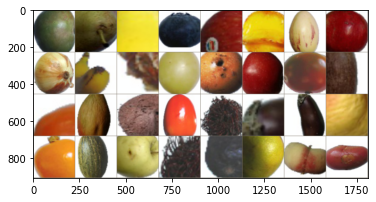

['Mango', 'Pear Forelle', 'Quince', 'Blueberry', 'Apple Red 1', 'Carambula', 'Pepino', 'Pomegranate', 'Onion White', 'Banana', 'Pineapple Mini', 'Grape White 2', 'Granadilla', 'Apple Braeburn', 'Tomato Maroon', 'Nut Pecan', 'Pepper Orange', 'Papaya', 'Cocos', 'Kaki', 'Rambutan', 'Eggplant', 'Eggplant', 'Apple Red Yellow 1', 'Physalis', 'Melon Piel de Sapo', 'Apple Golden 2', 'Rambutan', 'Avocado ripe', 'Pomelo Sweetie', 'Peach Flat', 'Potato Red Washed']


In [10]:
# transform 된 배치 이미지 시각화
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

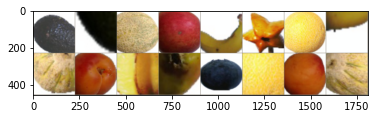

['Avocado ripe', 'Avocado', 'Cantaloupe 2', 'Apple Crimson Snow', 'Banana', 'Carambula', 'Cantaloupe 1', 'Banana', 'Cantaloupe 2', 'Apricot', 'Carambula', 'Apple Red Yellow 2', 'Blueberry', 'Cantaloupe 1', 'Apricot', 'Cantaloupe 2']


In [11]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# # 학습 데이터의 배치를 얻습니다.
# inputs, classes = next(iter(val_loader))

# # 배치로부터 격자 형태의 이미지를 만듭니다.
# out = torchvision.utils.make_grid(inputs)

# imshow(out)
# print([class_names[x] for x in classes])

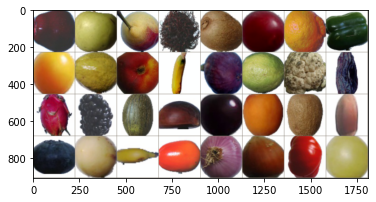

['Apple Red Delicious', 'Apple Golden 3', 'Pear 2', 'Rambutan', 'Kiwi', 'Cherry Wax Red', 'Mandarine', 'Pepper Green', 'Cherry Wax Yellow', 'Guava', 'Nectarine Flat', 'Banana Lady Finger', 'Fig', 'Limes', 'Cauliflower', 'Dates', 'Pitahaya Red', 'Mulberry', 'Melon Piel de Sapo', 'Chestnut', 'Cherry Wax Black', 'Apricot', 'Kiwi', 'Hazelnut', 'Blueberry', 'Pepino', 'Banana', 'Kaki', 'Onion Red Peeled', 'Nut Forest', 'Tomato 3', 'Grape White 2']


In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['test']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

In [12]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # print(f"time per 1 epoch: {time.time() - since:.2f}")

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'test']:
            if phase == 'train':
                # model.load_state_dict(model_state_dict)
                model.train()  # 모델을 학습 모드로 설정
            else:
                # model.load_state_dict(model_state_dict)
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar("Loss/train", epoch_loss, epoch)
            writer.add_scalar("Acc/train", epoch_acc, epoch)
            # wandb.log({'train_acc': epoch_acc, 'train_loss' : epoch_loss})

            # 모델을 깊은 복사(deep copy)함
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print("Update best acc! :", best_acc)
                best_model_wts = copy.deepcopy(model.state_dict())

       
        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    # wandb.log({'test_acc': best_acc})
    

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# from tqdm import tqdm
# # from sklearn.metrics import accuracy_score
# # from torch.utils.tensorboard import SummaryWriter

# # writer = SummaryWriter()

# def train_model(model, criterion, optimizer, scheduler, num_epochs):
#     model = model.to(device)
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in tqdm(range(num_epochs)):
        
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)
#         # print(f"time per 1 epoch: {time.time() - since:.2f}")

#         # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
#         # for phase in ['train']:
#         model.train()  # 모델을 학습 모드로 설정
            
#         running_loss = 0.0
#         running_corrects = 0

#         # 데이터를 반복
#         for inputs, labels in dataloaders['train']:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # 매개변수 경사도를 0으로 설정
#             optimizer.zero_grad()

#             # 순전파
#             # 학습 시에만 연산 기록을 추적
#             with torch.set_grad_enabled(True):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
            

#             # 통계
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#             scheduler.step()

#         epoch_train_loss = running_loss / len(train_set)
#         epoch_train_acc = running_corrects.double() / len(train_set)

#         print(f'train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
#             # writer.add_scalar("Loss/train", epoch_train_loss, epoch)
#             # writer.add_scalar("Acc/train", epoch_train_acc, epoch)
#             # wandb.log({'train_acc': epoch_acc, 'train_loss' : epoch_loss})

#         model.eval()

#         running_val_loss = 0.0
#         running_val_corrects = 0

#         for inputs, labels in val_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # 매개변수 경사도를 0으로 설정
#             optimizer.zero_grad()

#             # 순전파
#             # 학습 시에만 연산 기록을 추적
#             # with torch.set_grad_enabled(mode=False):
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             val_loss = criterion(outputs, labels)

#             # 통계
#             running_loss += val_loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#             scheduler.step()

#         epoch_val_loss = running_val_loss / len(val_set)
#         epoch_val_acc = running_val_corrects.float() / len(val_set)

#         print(f'val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
#         # writer.add_scalar("Loss/val", epoch_val_loss, epoch)
#         # writer.add_scalar("Acc/val", epoch_val_acc, epoch)
#         # wandb.log({'train_acc': epoch_acc, 'train_loss' : epoch_loss})

#         if epoch_train_acc > best_acc:
#             best_acc = epoch_train_acc
#             print(f'update best acc: {best_acc:4f}')
#             best_model_wts = copy.deepcopy(model.state_dict())
   
#         print()
#         time.sleep(0.01)

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Acc: {best_acc:4f}')
#     # print('Test result :', eval_result)
#     # wandb.log({'test_acc': best_acc})
    

#     # 가장 나은 모델 가중치를 불러옴
#     model.load_state_dict(best_model_wts)
#     return model

# def evaluate(model, criterion, eval_dataloader):
#     # Evaluation
#     model.eval()  # 모델의 AutoGradient 연산을 비활성화하고 평가 연산 모드로 설정 (메모리 사용 및 연산 효율화를 위해)
#     sum_eval_acc, sum_eval_loss = 0, 0
#     eval_result = {"mean_loss": 0, "mean_acc": 0}

#     eval_iterator = tqdm(  # Description 양식 지정
#         eval_dataloader, desc='Evaluating - mean_loss: XXX, mean_acc: XXX'
#     )

#     # Evaluate
#     for e_step, e_batch in enumerate(eval_iterator):
#         image_tensor, tags = map(lambda elm: elm.to(device), e_batch)  # device 에 연산용 텐서 할당
#         out = model(image_tensor)  # Calculate
#         loss = criterion(out, tags)

#         # Calculate acc & loss
#         sum_eval_acc += (out.max(dim=1)[1] == tags).float().mean().item()  # 정답과 추론 값이 일치하는 경우 정답으로 count
#         sum_eval_loss += loss.item()

#         # writer.add_scalar("Loss/test", sum_eval_loss, e_step)
#         # writer.add_scalar("Acc/test", sum_eval_acc, e_step)
#         # 평가 결과 업데이트
#         eval_result.update({"mean_loss": sum_eval_acc / (e_step + 1),
#                             "mean_acc": sum_eval_loss / (e_step + 1)})

#         # Step Description
#         eval_iterator.set_description(
#             'Evaluating - mean_loss: {:.3f}, mean_acc: {:.3f}'.format(
#                 eval_result['mean_loss'], eval_result['mean_acc'])
#         )
#     print(f'test Loss: {sum_eval_loss:.4f} Acc: {sum_eval_acc:.4f}')

#     # model.train()  # 평가 과정이 모두 종료 된 뒤, 다시 모델을 train 모드로 변경

#     return eval_result

In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 1.0020 Acc: 0.7482
test Loss: 0.1231 Acc: 0.9545
Update best acc! : tensor(0.9545, device='cuda:0', dtype=torch.float64)



  5%|▌         | 1/20 [33:26<10:35:29, 2006.79s/it]

Epoch 1/19
----------
train Loss: 0.2375 Acc: 0.9313


 10%|█         | 2/20 [1:06:52<10:01:55, 2006.40s/it]

test Loss: 0.0698 Acc: 0.9844
Update best acc! : tensor(0.9844, device='cuda:0', dtype=torch.float64)

Epoch 2/19
----------


 10%|█         | 2/20 [1:30:18<13:32:45, 2709.21s/it]


KeyboardInterrupt: 

In [ ]:
# evaluate(model, criterion, dataloaders['test'])

In [19]:
# model = ViG-Ti
from torchsummary import summary
import gc
gc.collect()
torch.cuda.empty_cache()

model_ti = pvig_ti_224()
model_ti = model_ti.to(device)
optimizer = optim.SGD(model_ti.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(summary(model_ti, (3,224,224)))

# train_model(model_ti, criterion, optimizer, exp_lr_scheduler,
#                        num_epochs=20)

<__main__.pvig_ti_224.<locals>.OptInit object at 0x7fb3703312e0>
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


/tmp/ipykernel_80123/3354495458.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


using relative_pos
using relative_pos
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             672
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              GELU-3         [-1, 24, 112, 112]               0
            Conv2d-4           [-1, 48, 56, 56]          10,416
       BatchNorm2d-5           [-1, 48, 56, 56]              96
              GELU-6           [-1, 48, 56, 56]               0
            Conv2d-7           [-1, 48, 56, 56]          20,784
       BatchNorm2d-8           [-1, 48, 56, 56]              96
              Stem-9           [-1, 48, 56, 56]               0
           Conv2d-10           [-1, 48, 56, 56]           2,352
      BatchNorm2d-11           [-1, 48, 56, 56]              96
     DenseDilated-12           [-1, 2, 3136, 9]               0
DenseDilatedKnnGraph-13           [-1, 2, 3136, 9]               

In [ ]:
evaluate(model_ti, criterion, dataloaders['test'])

In [20]:
# model = ViG-S
import gc
gc.collect()
torch.cuda.empty_cache()

model_s = pvig_s_224()
model_s = model_s.to(device)
optimizer = optim.SGD(model_s.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


print(summary(model_s, (3,224,224)))
# train_model(model, criterion, optimizer, exp_lr_scheduler,
#                        num_epochs=20)

<__main__.pvig_s_224.<locals>.OptInit object at 0x7fb384e99f10>
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


/tmp/ipykernel_80123/3354495458.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


using relative_pos
using relative_pos
using relative_pos
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,120
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              GELU-3         [-1, 40, 112, 112]               0
            Conv2d-4           [-1, 80, 56, 56]          28,880
       BatchNorm2d-5           [-1, 80, 56, 56]             160
              GELU-6           [-1, 80, 56, 56]               0
            Conv2d-7           [-1, 80, 56, 56]          57,680
       BatchNorm2d-8           [-1, 80, 56, 56]             160
              Stem-9           [-1, 80, 56, 56]               0
           Conv2d-10           [-1, 80, 56, 56]           6,480
      BatchNorm2d-11           [-1, 80, 56, 56]             160
     DenseDilated-12           [-1, 2, 3136, 9]               0
DenseDilatedKnnGraph-13           [-1, 2, 3136

In [21]:
# model = ViG-M
import gc
gc.collect()
torch.cuda.empty_cache()

model_m = pvig_m_224()
model_m = model_m.to(device)
optimizer = optim.SGD(model_m.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(summary(model_s, (3,224,224)))
# train_model(model_m, criterion, optimizer, exp_lr_scheduler,
#                        num_epochs=20)

<__main__.pvig_m_224.<locals>.OptInit object at 0x7fb3705f9490>
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


/tmp/ipykernel_80123/3354495458.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,120
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              GELU-3         [-1, 40, 112, 112]               0
            Conv2d-4           [-1, 80, 56, 56]          28,880
       BatchNorm2d-5           [-1, 80, 56, 56]             160
              GELU-6           [-1, 80, 56, 56]               0
            Conv2d-7           [-1, 80, 56, 56]          57,680
       BatchNorm2d-8           [-1, 80, 56, 56]             160
              Stem-9           [-1, 80, 56, 56]               0
          

# Pretrained CNN  
### Compared to resnet18 model

In [22]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.resnet18(pretrained=True)
model_ft = model_ft.to(device)

# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 12)
model_ft.fc = model_ft.fc.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
from torchinfo import summary

summary(model_ft, (64, 3,224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 12]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

In [48]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
----------
train Loss: 0.0498 Acc: 0.9864


 20%|██        | 1/5 [03:14<12:58, 194.63s/it]

val Loss: 0.3237 Acc: 0.8936
Update best acc! : tensor(0.8936, device='cuda:0', dtype=torch.float64)

Epoch 1/4
----------
train Loss: 0.0462 Acc: 0.9856


 40%|████      | 2/5 [06:30<09:45, 195.23s/it]

val Loss: 0.3239 Acc: 0.8887

Epoch 2/4
----------
train Loss: 0.0457 Acc: 0.9861


 60%|██████    | 3/5 [09:46<06:31, 195.60s/it]

val Loss: 0.3562 Acc: 0.8874

Epoch 3/4
----------
train Loss: 0.0497 Acc: 0.9846


 80%|████████  | 4/5 [13:01<03:15, 195.33s/it]

val Loss: 0.3600 Acc: 0.8820

Epoch 4/4
----------
train Loss: 0.0481 Acc: 0.9851


100%|██████████| 5/5 [16:17<00:00, 195.42s/it]

val Loss: 0.3249 Acc: 0.9017
Update best acc! : tensor(0.9017, device='cuda:0', dtype=torch.float64)

Training complete in 16m 17s
Best val Acc: 0.901733


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  